# < 내가 원하는 숫자 이미지 만들기!!! >

#  (1) Generator 구성하기

### 데이터 준비하기

#### tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러와 확인해 봅시다.

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


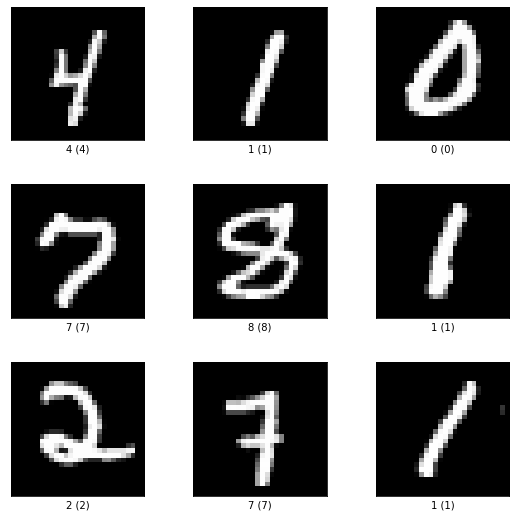

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

#### 여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었을 것입니다.

#### 이어서 아래 코드를 실행해 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의합니다

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

# GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1    # 이미지 픽셀 값을 -1~1 사이의 범위로 변경했고
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)    # 레이블 정보를 원-핫 인코딩(one-hot encoding)했습니다.
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("확인")

확인


#### 원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해 봅시다.

    1) 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 

    2)이미지 값의 범위가 -1~1 사이에 있어야 합니다.

Label : tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


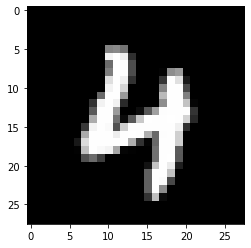

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

#### 원-핫 인코딩으로 표현된 Label과 출력된 이미지가 일치하는지 확인하는 법:


0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있습니다. 

MNIST의 경우, 

숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 

숫자 6은 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]의 값을 가집니다. 

이제 위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.

###  GAN Generator 구성하기

#### 이번 구현은 Tensorflow2의 Subclassing 방법을 이용하겠습니다.

#### Subclassing 방법이란, tensorflow.keras.Model 을 상속받아 클래스를 만드는 것.

이 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있습니다






#### 먼저 GAN의 Generator를 아래와 같이 구현합니다.

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):  # __init__() 메서드 안에서 레이어 구성을 정의
        super(GeneratorGAN, self).__init__()   #  tensorflow.keras.Model 을 상속받아 클래스를 만든다.

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')
        # __init__() 메서드 안에서 사용할 모든 레이어를 정의했습니다. 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인됩니다.

        self.reshape = layers.Reshape((28, 28, 1))
        # Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환됩니다.

    def call(self, noise):   # 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행
        # call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과합니다.
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("확인")

확인


### cGAN Generator 구성하기

#### 이번에는 cGAN 차례.

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        # 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다. (dense_z, dense_y)
        
        self.combined_dense = layers.Dense(512, activation='relu') 
        # 위의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다 (tf.concat, conbined_dense)
        
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh') 
        self.reshape = layers.Reshape((28, 28, 1))
        # 위의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력됩니다 (final_dense, reshape)


    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("확인")

확인


#### GAN의 Generator보다 구현이 복잡한듯하지만, 이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것뿐입니다

#### cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억해 주세요.

# (2) Discriminator 구성하기

### GAN Discriminator 구성하기

#### 이전에 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현했습니다. 

#### 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보겠습니다.

#### 먼저 GAN의 Discriminator를 아래와 같이 구현합니다.

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):   
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []                # 여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고,
        for f in [512, 256, 128, 1]:   # for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았습니다   (이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리합니다)
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        # Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 
        # 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용됩니다.
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
        # 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킵니다. 
        # 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.
    
print("완료")

완료


### cGAN Discriminator 구성하기

cGAN의 Discriminator는 **Maxout**이라는 특별한 레이어가 사용됩니다. 


**Maxout**은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜   ***그 중 가장 큰 값을 가져오도록 합니다***

만약 2개의 fully-connected 레이어를 사용할 때 Maxout을 식으로 표현하면 아래와 같습니다.



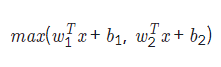

이렇게 fully-connected 레이어를 2개만 사용한다면 

다차원 공간에서 2개의 면이 교차된 모양의 activation function처럼 작동합니다. 

다차원 공간은 시각화 하기가 어려운데요. 

차원을 낮춰 1차원 fully-connected 레이어라고 가정하면 

아래처럼 2개의 직선으로 이루어진 activation function으로 나타낼 수 있습니다.

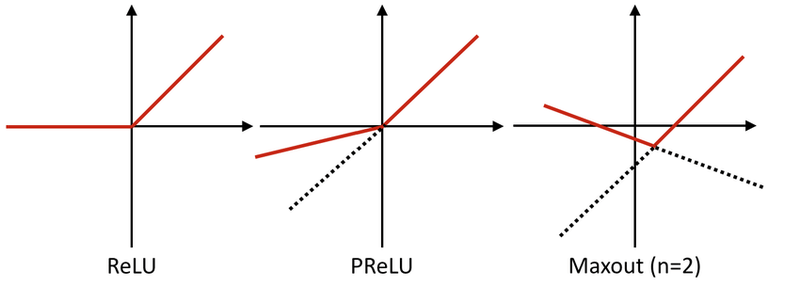

#### 아래 코드와 같이 Maxout을 구성할 수 있습니다.

In [7]:
class Maxout(layers.Layer):    
    # tensorflow.keras.layers.Layer 를 상속받아 레이어를 정의했습니다.
    
    # 이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성합니다.
    def __init__(self, units, pieces):
        # units 차원 수를 가진 fully-connected 레이어를 pieces개만큼 만들고 그중 최댓값을 출력합니다
        # 사용할 Maxout 레이어가 units=100, pieces=10으로 설정된다면 입력으로부터 100차원의 representation을 10개 만들고, 
        # 10개 중에서 최댓값을 가져와 최종 1개의 100차원 representation이 출력됩니다
        
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("완료")

완료


### cGAN의 Discriminator 구성
(Maxout 레이어를 3번만 사용)

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        # GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용.
        
        # (Maxout 레이어를 3번 사용)
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        #  그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한 번씩 통과한 후 서로 결합되어 Maxout 레이어를 한 번 더 통과
        
        self.dense = layers.Dense(1, activation=None)
        # 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됩니다.
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("완료")

완료


# (3) 학습 및 테스트하기

#### 이전에 정의한 Generator 및 Discriminator를 이용해 
#### MINST를 학습하고 각 모델로 *직접 숫자 손글씨를 생성해 봅시다.*

#### 우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 
#### *loss function*과 *optimizer*를 정의합니다.

#### 진짜 및 가짜를 구별하기 위해 
#### Binary Cross Entropy를 사용하고, 
#### Adam optimizer를 이용해 학습하겠습니다.

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("완")

완


### GAN으로 MNIST 학습하기

In [10]:
# 이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용합니다.
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    # 여기서는 입력으로 사용되는 노이즈를 100차원으로 설정
    noise = tf.random.normal([real_images.shape[0], 100])
        
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("완")

완


#### 위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 보겠습니다. 100번의 반복마다 각 손실(loss)을 출력하도록 했습니다.

In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.124483585357666, D:0.14638885855674744
[1/10 EPOCHS, 200 ITER] G:2.340515613555908, D:0.1459493637084961
[1/10 EPOCHS, 300 ITER] G:2.128068447113037, D:0.1822887808084488
[1/10 EPOCHS, 400 ITER] G:2.7070703506469727, D:0.10413156449794769
[2/10 EPOCHS, 100 ITER] G:3.9808971881866455, D:0.05249064415693283
[2/10 EPOCHS, 200 ITER] G:4.074853897094727, D:0.1166631430387497
[2/10 EPOCHS, 300 ITER] G:3.0122673511505127, D:0.21481764316558838
[2/10 EPOCHS, 400 ITER] G:4.198399543762207, D:0.16045868396759033
[3/10 EPOCHS, 100 ITER] G:3.1128275394439697, D:0.11812114715576172
[3/10 EPOCHS, 200 ITER] G:3.2461018562316895, D:0.24237458407878876
[3/10 EPOCHS, 300 ITER] G:4.560510158538818, D:0.17776717245578766
[3/10 EPOCHS, 400 ITER] G:3.357546806335449, D:0.10307405889034271
[4/10 EPOCHS, 100 ITER] G:5.073681354522705, D:0.13332776725292206
[4/10 EPOCHS, 200 ITER] G:3.974794626235962, D:0.10098128020763397
[4/10 EPOCHS, 300 ITER] G:3.3036141395568848, D:0.1291852891

#### 짧은 시간 학습된 모델을 테스트해 봅시다. 
#### 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화합니다.


#### 경고 메시지가 출력된다면 그냥 무시하셔도 됩니다.

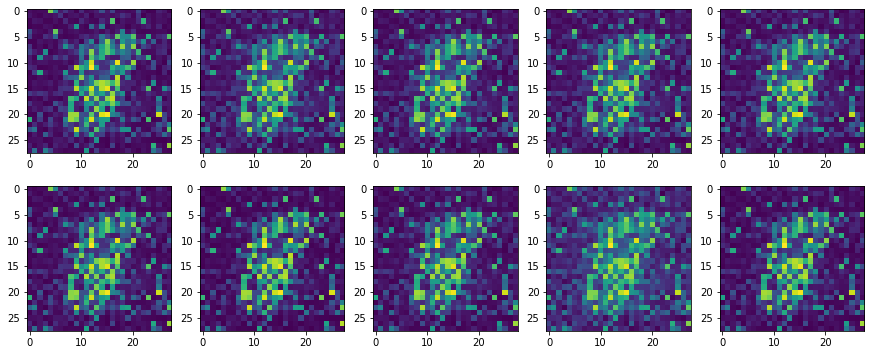

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### 띠용?

결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없나 봅니다.

위 구현을 그대로 500 epoch 학습한 가중치를 준비해 두었으니 한번 사용해 봅시다.

- 아래와 같이 작업환경을 구성해 주세요.

$ mkdir -p ~/aiffel/conditional_generation/gan

$ cp ~/data/gan/GAN_500.zip ~/aiffel/conditional_generation/gan/

$ cd ~/aiffel/conditional_generation/gan && unzip GAN_500.zip


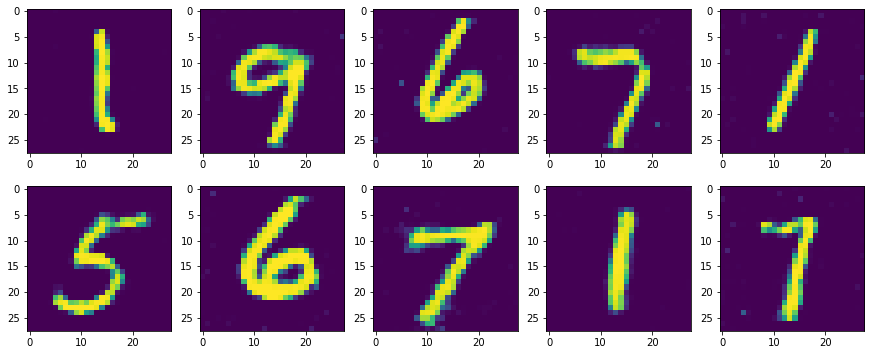

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화되었을 것입니다 (아닐 수도 있습니다).

이러한 방법으로는 **내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있습니다.** 

내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습 시켜 봅시다.

### cGAN으로 MNIST 학습하기

이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용합니다.

위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습 시켜 보겠습니다

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.409239768981934, D:0.006416224874556065
[1/1 EPOCHS, 199 ITER] G:5.631465911865234, D:0.004718136508017778
[1/1 EPOCHS, 299 ITER] G:4.150546550750732, D:0.05767332762479782
[1/1 EPOCHS, 399 ITER] G:4.83151388168335, D:0.023640600964426994


학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없습니다.

위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 합니다.

뒤에서 학습해야 할 것들이 많이 남아있으니, 시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 준비해 두었습니다.

- 아래와 같이 작업환경을 구성해 주세요.

$ mkdir -p ~/aiffel/conditional_generation/cgan

$ cp ~/data/cgan/CGAN_500.zip ~/aiffel/conditional_generation/cgan/

$ cd ~/aiffel/conditional_generation/cgan && unzip CGAN_500.zip

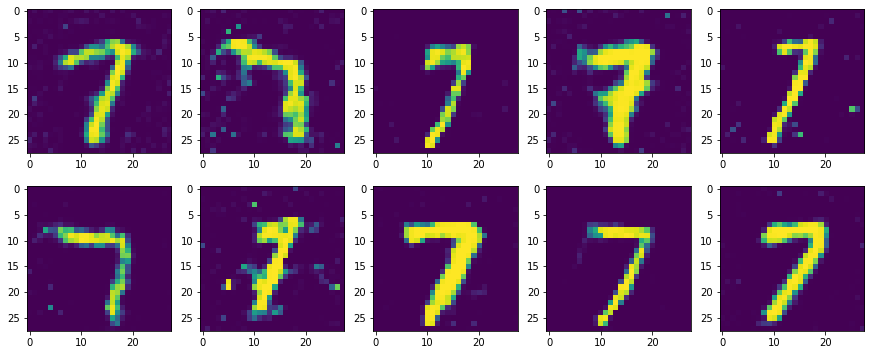

In [15]:
number =  7 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

출력된 10개 시각화 결과는 어떤가요? 아마도 number에 입력한 숫자에 해당하는 손글씨가 시각화되었을 것입니다.

**cGAN을 사용해** 조건을 주고 학습하면 이렇게 특정한 숫자를 만들어내기가 
# 훨씬 쉬워졌습니다.😆 (결론)


--------------------------------------------------

# < Pix2Pix >

### ~ GAN의 입력에 이미지를 넣는다면~
-----------------------------------------------------------------


지금까지 cGAN에 대해 알아보고 실험해 보면서, 

작은 조건만으로 우리가 **원하는 클래스의 이미지를 생성할 수 있음을 확인**했습니다.


## 그러나, 만약 입력 자체가 조건이 된다면?

### → 이미지 자체를 조건으로 준다면?

(cGAN 같은 겨우 클래스 레이블의 조건을 함께 입력하는 것이 아님)

### →  Pix2Pix

### → 기존 노이즈 입력을 원하는 이미지로 변환하는 일반적인 GAN (X)

### → 이미지 입력을 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델 (O)

### → 한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻에서 Pix2Pix

### → Image-to-Image Translation with Conditional Adversarial Networks 

### = Image-to-Image Translation with cGAN

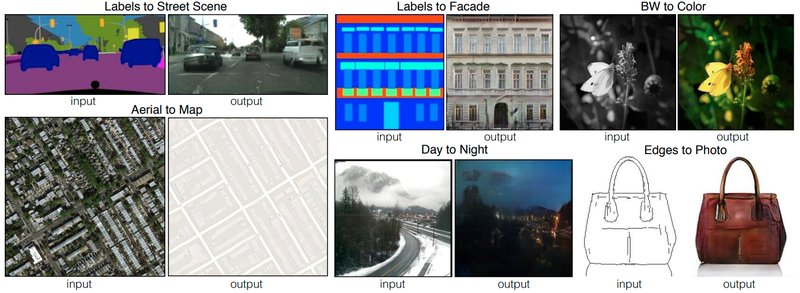

위 결과의 첫 번째 Labels to Street Scene 이미지는 픽셀 별로 레이블 정보만 존재하는 segmentation map을 입력으로 실제 거리 사진을 생성해 내었고, 

이 외에 흑백 사진을 컬러로 변환하거나, 

낮에 찍은 사진을 밤에 찍은 사진으로 변환하거나, 

#### 가방 스케치를 이용해 채색된 가방을 만들기도 합니다.

노이즈와 레이블 정보를 함께 입력했던 cGAN은 **fully-connected 레이어**를 연속적으로 쌓아 만들었지만, 

이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 **convolution 레이어**를 활용합니다. 

GAN 구조를 기반으로 하기 때문에 

크게 **Generator와 Discriminator 두 가지 구성 요소로 이루어집니다**

아래에서 자세히 알아보겠습니다.

# Pix2Pix (Generator)
--------------------------------------------------------------------

Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용됩니다. 

여기서 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 

이러한 문제에서 흔히 사용되는 구조는 아래 그림과 같은 Encoder-Decoder 구조입니다.

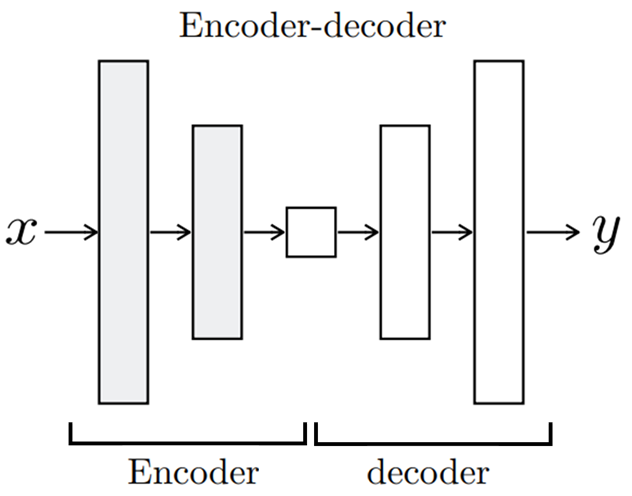

Encoder에서 입력 이미지(x)를 받으면 

단계적으로 이미지를 down-sampling 하면서 

입력 이미지의 중요한 representation을 학습합니다. 

Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling하여 

입력 이미지와 동일한 크기의 변환된 이미지(y)를 생성해냅니다. 

이러한 과정은 모두 convolution 레이어로 진행되며, 

레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 합니다. 

여기서 한 가지 짚고 넘어갈 부분은, 

Encoder의 최종 출력은 

위 그림 중간에 위치한 가장 작은 사각형이며, 

bottleneck 이라고도 불리는 이 부분은 

입력 이미지(x)의 가장 중요한 특징만을 담고 있습니다.

과연 이 중요하지만 작은 특징이 변환된 이미지(y)를 생성하는데 

충분한 정보를 제공할까요? 

이와 같은 점을 보완하기 위해 

논문에서는 Generator 구조를 하나 더 제안합니다.


아래 그림과 같은 U-Net 구조입니다.

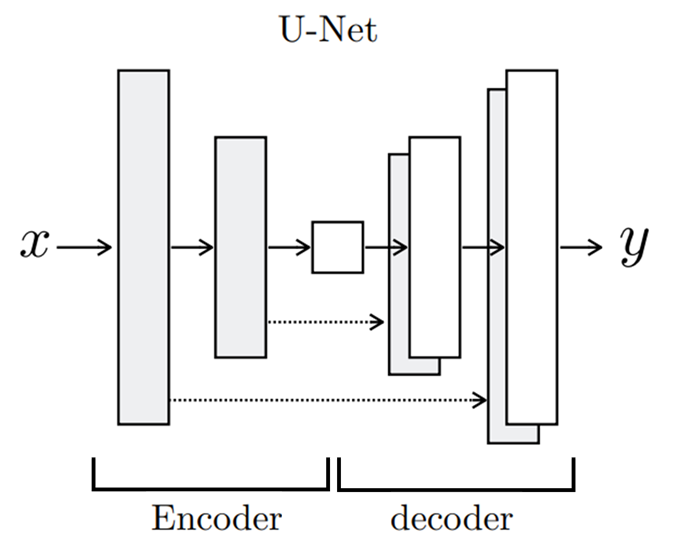

위에서 살펴본 단순한 Encoder-Decoder로 구성된 Generator와 다른 점은,

각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것입니다. 

Decoder가 변환된 이미지를 더 잘 생성하도록 

Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 

이러한 U-Net 구조의 Generator를 사용해 

아래와 같이 단순한 Encoder-Decoder 구조의 Generator를 사용한 결과에 비해 

**비교적 선명한 결과를 얻을 수 있었습니다.**

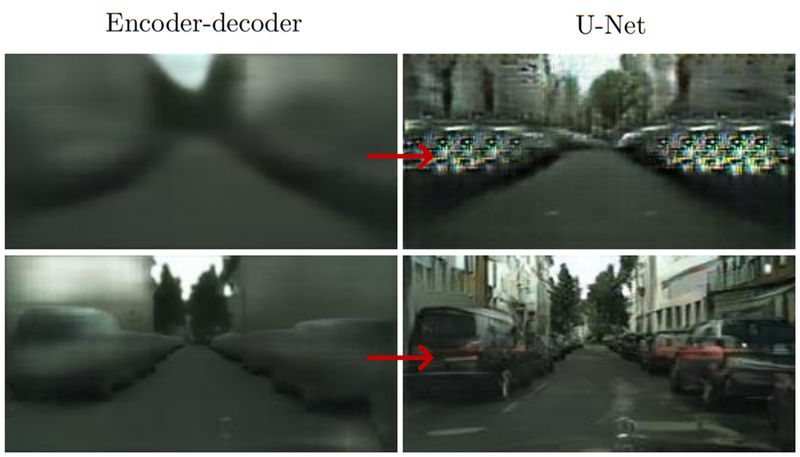

----------------------------------------------------------
# 본격적인 스케치 - 채색을 해보자!

# (1) 데이터 준비하기
----------------------------------------------------------

- pix2pix 모델에 대해서 직접 구현하고 실험해보자.

    Sketch2Pokemon이라는 데이터셋을 사용한다.


아래 명령어를 사용해 데이터를 준비해 주세요.

$ mkdir -p ~/aiffel/conditional_generation/data

$ ln -s ~/data/sketch2pokemon.zip ~/aiffel/conditional_generation/data

$ cd ~/aiffel/conditional_generation/data && unzip sketch2pokemon.zip

In [16]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


830개 이미지가 있음을 확인할 수 있습니다

이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 봅시다. 

학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.

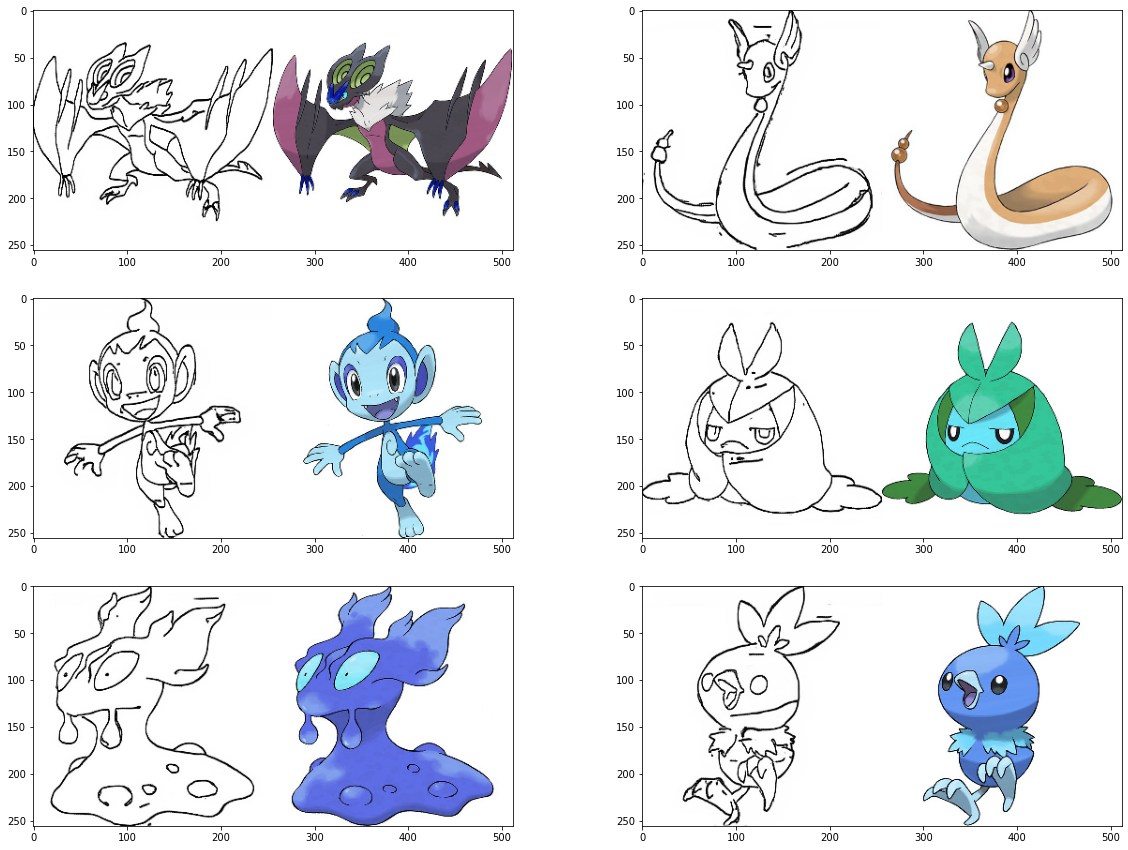

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음
-  위 코드를 여러 번 반복 실행해 보면 일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있습니다. (직접 그린게 아닌 스케치 생성 모델을 사용해서)

이미지를 하나 열어 아래와 같이 크기를 확인해 보겠습니다.

In [18]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되었습니다. 

모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같네요.

아래 코드로 이미지를 나누어 봅시다.

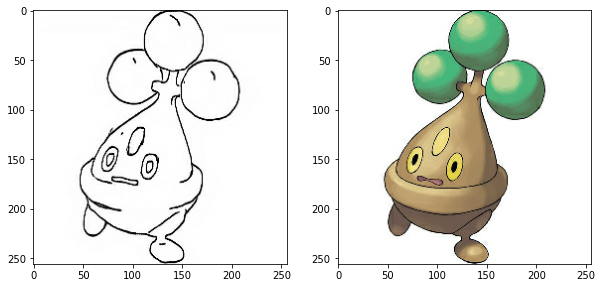

In [19]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

위와 같이 두 개 이미지로 나누었습니다. 

### 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 

### 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표입니다.

앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐입니다.

학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

In [20]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):    # apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용합니다
    stacked = tf.concat([sketch, colored], axis=-1)    # 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])    # 위의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])    # 위의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
    
    out = image.random_flip_left_right(out)    # 위의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    out = image.random_flip_up_down(out)       # 위의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
    
    if tf.random.uniform(()) < .5:   # 위의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("완")

완


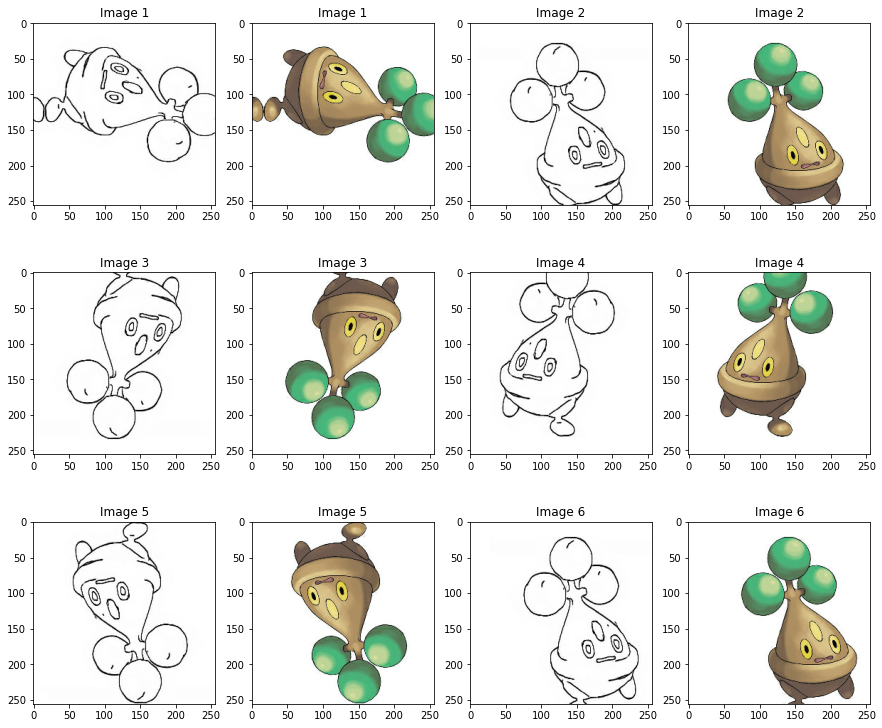

In [21]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

매우 다양한 이미지가 생성됩니다. 

### 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 

더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있습니다.

마지막으로 위 과정들을 학습 데이터에 적용하며, 

잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

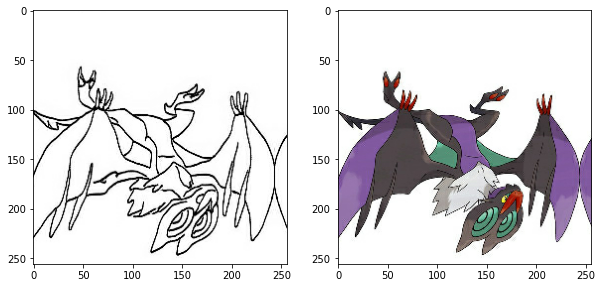

In [22]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# (2) Generator 구성하기
----------------------------------------------

**본격적으로 Pix2Pix 구조를 구현함.**

(앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠)

### Generator의 구성요소 알아보기
-------------------------------------------------------------------------

Generator를 구성하는데 필요한 레이어

-   encoder의 "C64":
    
    LeakyReLU 레이어의 조합

    (하이퍼파라미터 : 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope)
    
-  decoder의 "CD512":
    
    Convolution → BatchNorm → 50% Dropout → ReLU  레이어들의 조합
    
    (하이퍼파라미터 : 512개의 4x4 필터에 stride 2를 적용한 (Transposed)

~ 그림으로 쉽게 표현한 Generator의 전체 구조 ~

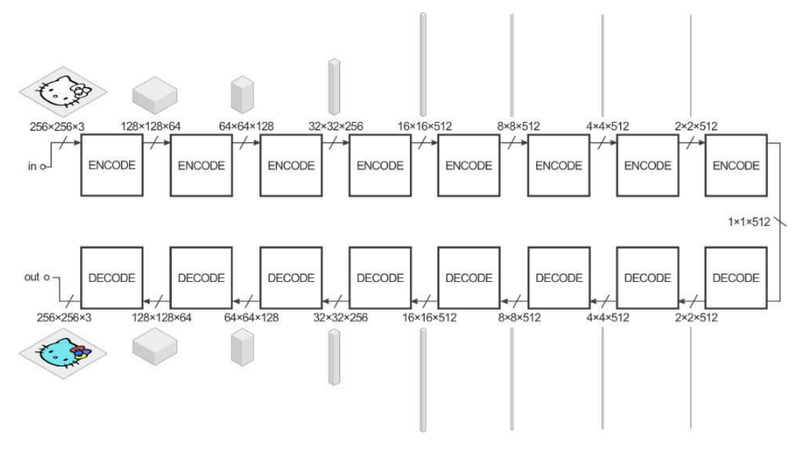

위 그림에서 ENCODE 또는 DECODE라고 쓰인 각각의 블록을 기준으로 양쪽에 쓰인 입출력 크기에 집중

-------------------------
Encoder 부분  [범위 : 처음 입력 ~ (1,1,512) 출력]

"in"으로 시작

(width, height) 크기가 절반씩 줄어듦. 최종적으로 (1,1)이 됨.

채널의 수는 512까지 늘어남.


--------------------------

Decoder 부분  [범위 : (1,1,512) 입력 ~ 최종 출력]

아랫줄 화살표를 따라가면

(width, height) 크기가 두배로 늘어남. 최종적으로 (256, 256)가 됨.

채널의 수는 3까지 줄어듦.



### Generator 구현하기
----------------------------

**Generator의 Encoder 부분을 구현하겠습니다.**

    "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었습니다.

In [23]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):   # n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        #  Convolution 레이어에서 필터의 크기(=4) 및 stride(=2) 는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했습니다.
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)
        #  LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했습니다.

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("완")

완


Encoder에 사용할 기본 블록을 구성했으니 

이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있습니다.

In [24]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512] # 각 블록을 거치면서 사용할 필터의 개수
        
        self.blocks = []  # blocks이라는 리스트에는 사용할 블록들을 정의해 넣어둠.
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):   # call() 메서드에서 차례대로 블록들을 통과합니다
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):   # get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("완")

완


 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅시다. 만들어 놓은 get_summary 메서드를 바로 불러오시면 됩니다.

# (3) Generator 재구성하기
---------------------------------------------

Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지가 존재한다.

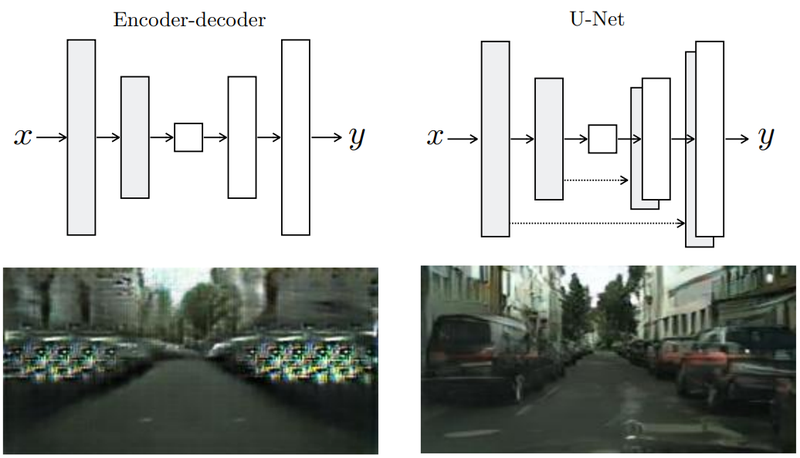

단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 
## U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다

이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조입니다(왼쪽)
(추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다.)

## 더 좋은 결과를 기대하기 위해 (위 그림의) U-Net 구조를 만들고 실험해 봅시다.

먼저 Encoder 및 Decoder에 사용되는 **기본적인 블록**은 이전에 아래 코드와 같이 구현했었습니다.

In [25]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("완")

완


그대로 가져다가 사용하겠습니다.(여기서 특별히 수정해야 할 부분은 없습니다.)

정의된 블록들을 이용해 한 번에 U-Net Generator를 정의해 보겠습니다.

아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 합니다. 

이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해 봅시다.

In [26]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []  #  (1) __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []  #  (2) __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):  #  (3) __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.
        features = []   #  ① Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)  #  ② Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.
        
        features = features[:-1]
        # features = features[:-1] 는 왜 필요할까요?
        # Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아닙니다.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):    #  ③ 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
        # features[::-1] 는 왜 필요할까요?
        # Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룹니다(맨 위 U-Net 구조 사진 참고). features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결합니다.
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x  #  ④ features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("완")

완


이제야 Generator 구현이 끝났습니다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해 봅시다.

In [27]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

이전 Encoder-Decoder Generator 구조에서 학습해야 할 파라미터는 약 4000만 개였는데, 

#### Skip connection을 추가한 U-Net Generator의 파라미터는 약 5500만 개로 꽤나 많이 늘어났습니다.

#### Q. U-Net Generator의 파라미터가 늘어난 곳은 Encoder와 Decoder 중 어디일까요?
또한, 두 종류의 Generator 구조에서 동일한 수의 convolution 레이어를 사용했는데, 구체적으로 어느 부분에서 파라미터가 늘어났을까요?

A. U-Net Generator의 Decoder 구조 내 파라미터가 많아졌습니다. 이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다릅니다.

예를 들어, 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면,
Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 입니다.

U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 입니다.

-------------------------------------------------------



정리하면, U-Net Generator에서 사용한 **skip-connection으로 인해 Decoder**의 각 블록에서 입력받는 
## 채널 수가 늘어났고, 

이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서
## 학습해야 할 파라미터가 늘어났습니다.



# (4) Discriminator 구성하기
-----------------------------------

Generator만으로 좋은 결과를 도출하기에는 부족합니다.

→ Discriminator가 필요합니다.


이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 봅시다.

### Discriminator의 구성요소 알아보기
--------------------------------


- **Generator의 구성 요소와 똑같**이 "C64" 등으로 표기되어 있습니다.

- 진짜 및 가짜 이미지를 판별하기 위해 **최종 출력에 sigmoid를 사용하는 것**을 제외하면 특별한 변경 사항은 없는 것 같습니다.

<그림>
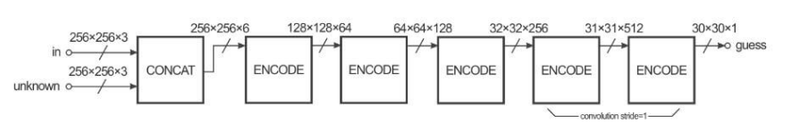

1. Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, 

2. ENCODE 라고 쓰인 5개의 블록을 통과합니다. 

3. 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 

4. 마지막은 1(채널)차원 출력을 위한 블록이 추가되었습니다.

최종적으로 출력되는 크기는 (30,30,1)

ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있습니다 (마지막 2개 블록에서)

Q. 그림과 같이 1씩 감소하도록 하려면 어떻게 해야할까?

    (↔ Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것입니다. 

    1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소한다.)
    
A. DiscBlock의 설정을 다음과 같이 한다.
 
     DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True)
    
    
    (추가적으로 위 그림에서 최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문입니다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다.)

이 부분만 제외하면 전반적으로는 **Generator보다 간단**한 것 같습니다. 구현해 봅시다.

### Discriminator 구현하기
-------------------

마찬가지로 Discriminator에 사용할 **기본적인 블록**부터 만들겠습니다.

In [29]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        # 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("완")

완


 DiscBlock의 설정을 다음과 같이 한다.
 
 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True)